# Simulating Relax displacements with a basal dislocation

## Getting a sense for the output: Make a single pyGMT plot

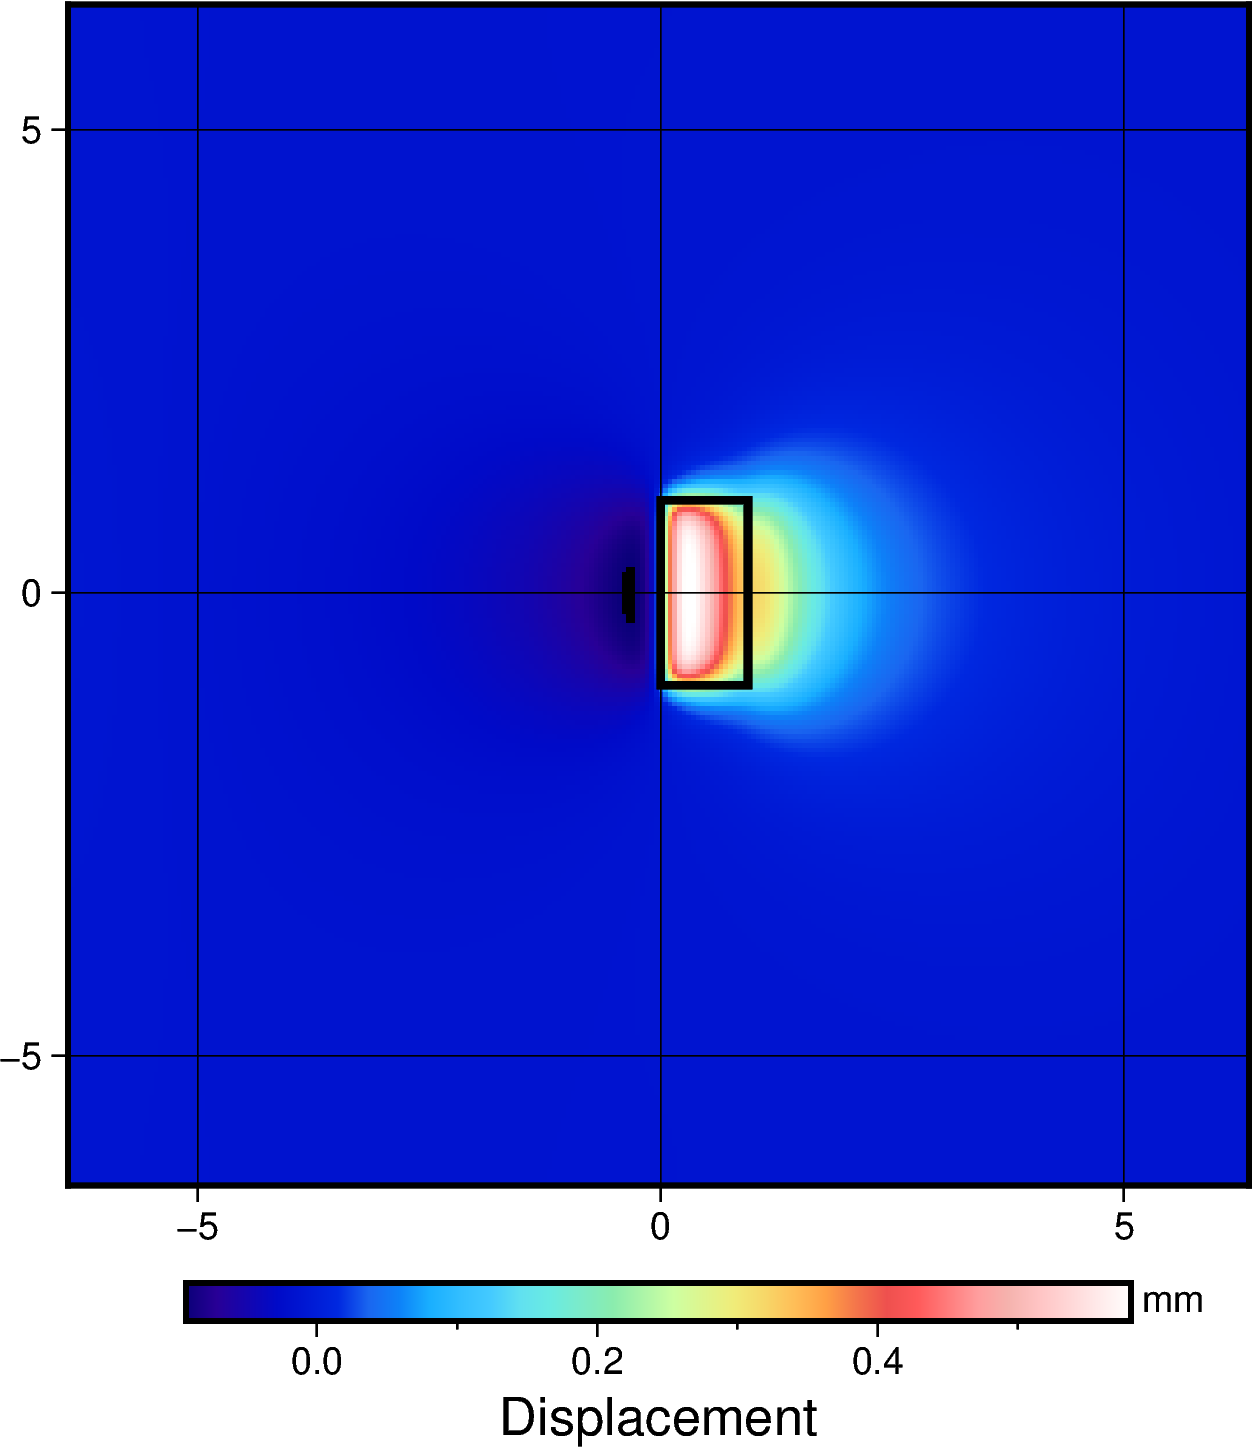

In [1]:
import pygmt

directory = "/Users/jloveles/Documents/relax/examples/tutorials/output2_dipping"
pathname = directory + "/000-east.grd"
faultname = directory + "/rfaults-001.xy"
grid = pygmt.load_dataarray(pathname)

# Get z limits from grdinfo
info = pygmt.grdinfo(pathname, nearest_multiple="+a0.1")

fig = pygmt.Figure()
pygmt.makecpt(cmap="haxby", series=info[2:])
fig.grdimage(grid=grid, projection="X10c", frame="ag")
fig.colorbar(frame=["x+lDisplacement", "y+lmm"])

pygmt.makecpt(cmap="gray", series=[0, 2000])
fig.plot(faultname, close=True, pen="2p")

fig.show()

## Set up triangular dislocation sources

In [2]:
def tri_horizon(x, y, z, el_size):
    # Makes a simple ~horizon of triangular dislocation elements using Gmsh
    # x, y are 2-element arrays defining horizontal bounds
    # z is a scalar giving depth 
    # el_size gives nominal element size 

    import gmsh
    import meshio
    
    # Mesh construction using Gmsh
    gmsh.initialize()
    # Define points
    gmsh.model.geo.addPoint(x[0], y[0], z+0.01, el_size, 1)
    gmsh.model.geo.addPoint(x[1], y[0], z-0.01, el_size, 2)
    gmsh.model.geo.addPoint(x[1], y[1], z-0.01, el_size, 3)
    gmsh.model.geo.addPoint(x[0], y[1], z+0.01, el_size, 4)
    # Boundary lines
    gmsh.model.geo.addLine(1, 2, 1)
    gmsh.model.geo.addLine(2, 3, 2)
    gmsh.model.geo.addLine(3, 4, 3)
    gmsh.model.geo.addLine(4, 1, 4)
    # Perimeter
    gmsh.model.geo.addCurveLoop([1, 2, 3, 4], 1)
    # Surface
    gmsh.model.geo.addPlaneSurface([1], 1)
    gmsh.model.geo.synchronize()
    # Generate and write. Writing a file allows use of meshio, consistent with celeri codes
    gmsh.model.mesh.generate(2)
    gmsh.write("file.msh")
    gmsh.finalize()

    # Read and parse mesh
    mesh = meshio.read("file.msh")
    fault_pts = mesh.points
    fault_tri = meshio.CellBlock("triangle", mesh.get_cells_type("triangle")).data
    return fault_pts, fault_tri

### Circular mesh test

Info    : Meshing 1D...
Info    : Meshing curve 1 (Circle)
Info    : Done meshing 1D (Wall 0.000144083s, CPU 0.000144s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0165773s, CPU 0.016145s)
Info    : 411 nodes 821 elements
Info    : Writing 'circle.msh'...
Info    : Done writing 'circle.msh'


(-109.86947672798689,
 109.99378460609461,
 -109.96581002008978,
 109.96581002008979)

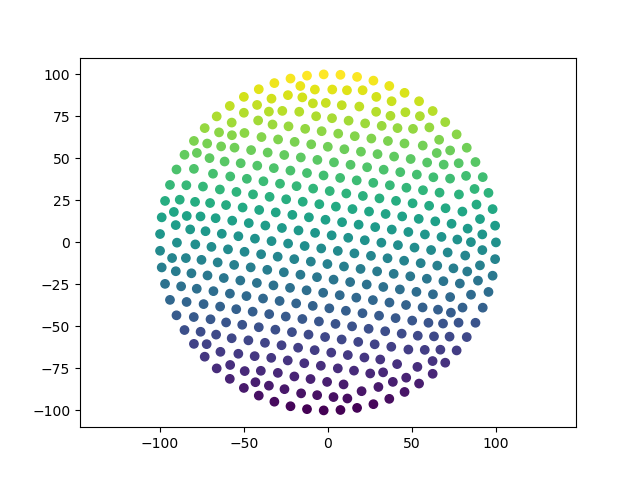

In [3]:
import gmsh 
import meshio
import numpy as np
import matplotlib 
from matplotlib import pyplot as plt
%matplotlib widget 

gmsh.initialize()
# Specify x, y, z, radius as first four arguments
gmsh.model.occ.addCircle(0.0, 0.0, 0.0, 100.0, 1, angle1=0., angle2=2*np.pi)
gmsh.model.occ.addCurveLoop([1], 1)
gmsh.model.occ.addPlaneSurface([1], 1)
gmsh.model.occ.synchronize()
# Set the mesh size by changing the 10 (same units as the x, y, z, radius)
gmsh.model.mesh.setSize([(0, 1)], 10)
gmsh.model.mesh.generate(2)
gmsh.write("circle.msh")
gmsh.finalize()

# Read and parse mesh
circ = meshio.read("circle.msh")
circ_pts = circ.points
circ_tri = meshio.CellBlock("triangle", circ.get_cells_type("triangle")).data

# Nominal depth of 15 km
nominal_z = -15000
# Dip coefficient, to be multiplied by y coordinates
dip_coefficient = np.tan(np.radians(1))*(np.min(circ_pts[:, 1]) - np.max(circ_pts[:, 1]))
# Define the new z coordinates: exactly 15 km at the northernmost node, dipping 1º south
tri_coords_z = nominal_z - dip_coefficient*(circ_pts[:, 1] - np.max(circ_pts[:, 1]))

fig, ax = plt.subplots()
ax.scatter(circ_pts[:, 0], circ_pts[:, 1], c=tri_coords_z)
ax.axis('equal')


## Define source mesh and horizon

In [4]:
def make_meshes(source_len, source_ldep, source_bdep, source_dip, horiz_x, horiz_y, horiz_z, horiz_el_size):
    
    import addict

    # Define source fault
    meshes = []
    meshes.append(addict.Dict())
    source_len = 2
    source_ldep = 1
    source_bdep = 0
    source_dip = 20*np.pi/180
    # Fault coordinates
    meshes[0].coords = np.array([[0.01, -source_len/2, source_bdep], [0.01, source_len/2, source_bdep], [0.01+source_ldep*np.cos(source_dip), source_len/2, -source_ldep*np.sin(source_dip)], [0.01+source_ldep*np.cos(source_dip), -source_len/2, -source_ldep*np.sin(source_dip)]])
    meshes[0].verts = np.array([[0, 1, 2], [0, 2, 3]], dtype=np.int64)

    # Define source fault
    meshes = []
    meshes.append(addict.Dict())
    source_len = 2
    source_ldep = 1
    source_bdep = 0
    source_dip = 20*np.pi/180
    # Fault coordinates
    meshes[0].coords = np.array([[0.01, -source_len/2, source_bdep], [0.01, source_len/2, source_bdep], [0.01+source_ldep*np.cos(source_dip), source_len/2, -source_ldep*np.sin(source_dip)], [0.01+source_ldep*np.cos(source_dip), -source_len/2, -source_ldep*np.sin(source_dip)]])
    meshes[0].verts = np.array([[0, 1, 2], [0, 2, 3]], dtype=np.int64)

    # Define horizontal mesh
    meshes.append(addict.Dict())
    meshes[1].coords, meshes[1].verts = tri_horizon(horiz_x, horiz_y, horiz_z, horiz_el_size)
    # nsource_tri = np.shape(meshes[0].verts)[0]
    nsource_tri = 0
    nhoriz_tri = np.shape(meshes[1].verts)[0]
    ntri = nsource_tri + nhoriz_tri

    # Concatenate source and horizontal
    source_tri_pts = meshes[0].coords[meshes[0].verts]
    horiz_tri_pts = meshes[1].coords[meshes[1].verts]
    all_tri_pts = np.concatenate((source_tri_pts, horiz_tri_pts), axis=0)

    # Calculate element normals, strike and dip
    meshes[0].normal_vector = np.cross(source_tri_pts[:, 1, :] - source_tri_pts[:, 0, :], source_tri_pts[:, 2, :] - source_tri_pts[:, 0, :])
    meshes[1].normal_vector = np.cross(horiz_tri_pts[:, 1, :] - horiz_tri_pts[:, 0, :], horiz_tri_pts[:, 2, :] - horiz_tri_pts[:, 0, :])
    return meshes

    # Calculate TDE partials for the full array, for comparison with full Relax grid
    # obsg_full = np.array([Xg, Yg, 0*Yg]).reshape((3, -1)).T.copy()
    # disp_mat_full = cutde_halfspace.disp_matrix(obs_pts=obsg_full, tris=horiz_tri_pts, nu=0.25)

# Set up inversion of Relax displacements

## Matrix assembly

In [5]:
def matrix_assembly(meshes, disp_mat, smoothing_weight):
    
    import celeri 
    import addict 
    
    # Get triangular smoothing matrix
    operators = addict.Dict()
    celeri.get_all_mesh_smoothing_matrices_simple(meshes, operators)

    nobs = 3*np.size(disp_mat, axis=0)
    ntri = np.size(disp_mat, axis=2)
    nsource_tri = ntri - np.size(meshes[1].verts, axis=0)
    # nsource_tri = np.size(meshes[0].verts, axis=0)

    # Assemble matrices
    assembled_mat = np.zeros((nobs+3*ntri, 3*ntri))
    # Insert elastic partials
    assembled_mat[0:nobs, :] = disp_mat.reshape((-1, 3*ntri))
    # Insert smoothing matrices
    source_row_start = nobs
    source_row_end = source_row_start + 3*nsource_tri
    # assembled_mat[source_row_start:source_row_end, 0:3*nsource_tri] = operators.smoothing_matrix[0].toarray()
    assembled_mat[source_row_end:, 3*nsource_tri:] = operators.smoothing_matrix[1].toarray()

    # Assemble weighting vector
    weights = np.ones((np.shape(assembled_mat)[0], 1))
    weights[source_row_start:] = smoothing_weight

    return assembled_mat, weights

## Sequential reading and inversion of displacement grids

In [8]:
import glob
import cutde.halfspace as cutde_halfspace
import numpy as np 
###
### GEOMETRY ELEMENTS
###

# Get stations from grid plotted above
gsubset = 10 # Subset of grid points: increment every gsubset points along grid
xg = np.array(grid.x)
yg = np.array(grid.y)
Xg, Yg = np.meshgrid(xg, yg)
obsg = np.array([Xg[0::gsubset, 0::gsubset], Yg[0::gsubset, 0::gsubset], 0*Yg[0::gsubset, 0::gsubset]]).reshape((3, -1)).T.copy()

# Template mesh. Depth will be adjusted for each model 
# We're only going to use the horizon, so we can ignore the source properties specified here
meshes = make_meshes(source_len=2, source_ldep=1, source_bdep=0, source_dip=20, horiz_x=[-10, 10], horiz_y=[-10, 10], horiz_z=0, horiz_el_size=0.75)
horiz_tri_pts = meshes[1].coords[meshes[1].verts]
ntri = np.size(horiz_tri_pts, axis=0)
n_source_tri = 0
source_row_start = np.size(obsg)

###
### PARAMETER RANGES
###

# List of dips to test
dips = np.arange(10, 100, 10)
# dips = np.arange(30, 40, 10)

# List of depth multipliers: 
# Fault depth will be calculated, then multiplied by depth multiplier to define thickness of elastic layer
depth_mults = np.arange(1, 4, 1).astype(float)
# depth_mults = np.arange(3, 4, 1).astype(float)

# List of viscosities to test
# Framed as gammadot = 1/Maxwell time
maxwell_times = np.array([10, 5, 1])
# maxwell_times = np.array([1])
viscosities = 1./maxwell_times

# List of smoothing weights to test
smooths = [1e-6, 1e-3, 1e0]

###
### ALLOCATE SPACE FOR ALL RESULTS
###

# Allocate space for estimated slip and predicted displacements
# Hard coded for 500 time steps; can trim unused columns later
n_trials = len(dips)*len(depth_mults)*len(smooths)*len(viscosities)
est_slip = np.zeros((3*ntri, 500, n_trials))
pred_disp = np.zeros((obsg.size, 500, n_trials))
time_vectors = np.zeros((500, n_trials))

# Allocate space for data vector
data_vector = np.zeros(source_row_start+3*ntri)

# Selected times
sel_times = np.array([1, 10, 20])

totalidx = -1
for dipi in range(len(dips)):
    for depthi in range(len(depth_mults)):
        # Calculate elastic partial derivatives for this particular horizon configuration
        
        # Define horizon at set depth
        fault_depth = np.sin(np.radians(dips[dipi])) # Fault width is 1 
        thick = depth_mults[depthi]*fault_depth # Thickness of elastic layer 
        
        # Adjust depth of triangle coordinates
        these_horiz_tri_pts = np.copy(horiz_tri_pts)
        these_horiz_tri_pts[:, :, 2] = horiz_tri_pts[:, :, 2] - thick

        # Calculate partial derivatives
        disp_mat = cutde_halfspace.disp_matrix(obs_pts=obsg, tris=these_horiz_tri_pts, nu=0.25)

        for smoothi in range(len(smooths)):
            # Assemble with smoothing
            assembled_mat, weights = matrix_assembly(meshes, disp_mat, smoothing_weight=smooths[smoothi])

            # Calculate model covariance
            cov = np.linalg.inv(assembled_mat.T * weights.T @ assembled_mat) 

            for visci in range(len(viscosities)):
                totalidx += 1
                sh_name = 'dip{:}_z{:}_eta{:0.2}.sh'.format(dips[dipi], depth_mults[depthi], viscosities[visci])
                directory = f"./tutorials/parameter_ranges/output_{sh_name[:-3]}".format()
                time_vector = np.loadtxt(directory + "/time.txt", unpack=False)
                time_vectors[0:len(time_vector), totalidx] = time_vector
                
                sel_times_idx = np.nonzero(np.isin(time_vector, sel_times))[0]
                
                # Read sequence of displacement grd files and invert
                e_disp_file_list = sorted(glob.glob(directory + "/*-relax-east.grd"))
                n_disp_file_list = sorted(glob.glob(directory + "/*-relax-north.grd"))
                u_disp_file_list = sorted(glob.glob(directory + "/*-relax-up.grd"))

                # Read each file and invert 
                # for i in range(len(e_disp_file_list)):
                for i in sel_times_idx:
                    # Read components
                    e_disp = pygmt.load_dataarray(e_disp_file_list[i])
                    n_disp = pygmt.load_dataarray(n_disp_file_list[i])
                    u_disp = pygmt.load_dataarray(u_disp_file_list[i])
                    # Take the same subset as when setting up partials
                    disp_array = np.array([e_disp[0::gsubset, 0::gsubset], n_disp[0::gsubset, 0::gsubset], u_disp[0::gsubset, 0::gsubset]]).reshape((3, -1)).T.copy()
                    data_vector[0:source_row_start] = disp_array.flatten()
                    # Estimate slip using pre-calculated covariance
                    est_slip[:, i, totalidx] = cov @ assembled_mat.T * weights.T @ data_vector 
                    # Predict displacement at the full grid resolution
                    pred_disp[:, i, totalidx] = disp_mat.reshape((-1, 3*ntri)).dot(est_slip[:, i, totalidx])

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000199709s, CPU 0.000278s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.015172s, CPU 0.014911s)
Info    : 922 nodes 1846 elements
Info    : Writing 'file.msh'...
Info    : Done writing 'file.msh'


### Write H5 files with estimated slip and predicted displacements

In [15]:
import h5py
slipf = h5py.File("./tutorials/parameter_ranges/est_slip.h5", "w")
dset = slipf.create_dataset("est_slip", data=est_slip)
slipf.close()

dispf = h5py.File("./tutorials/parameter_ranges/pred_disp.h5", "w")
dset = dispf.create_dataset("pred_disp", data=pred_disp)
dispf.close()

### Read H5 files back in

In [6]:
import h5py
import numpy as np 
slipf = h5py.File("./tutorials/parameter_ranges/est_slip.h5", "r")
est_slip = np.array(slipf.get("est_slip"))
slipf.close()

dispf = h5py.File("./tutorials/parameter_ranges/pred_disp.h5", "r")
pred_disp = np.array(dispf.get("pred_disp"))
dispf.close()

## Plot results

### Displacement grids (pyGMT; east component only)

In [ ]:
# Get z limits from grdinfo
info = pygmt.grdinfo(e_disp_file_list[-1], nearest_multiple="+a0.01")

# Make a time series array for all north displacements
e_disp_array = np.zeros((np.shape(obsg_full)[0], len(e_disp_file_list)))
n_disp_array = np.zeros((np.shape(obsg_full)[0], len(n_disp_file_list)))
u_disp_array = np.zeros((np.shape(obsg_full)[0], len(u_disp_file_list)))

mod_num = totalidx

sel_times = np.array([1, 10, 20])
sel_times_idx = np.nonzero(np.isin(time_vector, sel_times))[0]

# For all time steps,
# for i in range(len(e_disp_file_list)):
for i in sel_times_idx:
    # Convert predicted displacements to xarrays
    eastdispg = xa.DataArray.copy(grid)
    eastdispg.values = np.reshape(pred_disp[0::3, i, mod_num], (256, 256))
    northdispg = xa.DataArray.copy(grid)
    northdispg.values = np.reshape(pred_disp[1::3, i, mod_num], (256, 256))
    updispg = xa.DataArray.copy(grid)
    updispg.values = np.reshape(pred_disp[2::3, i, mod_num], (256, 256))
    # Read in Relax displacements
    e_disp = pygmt.load_dataarray(e_disp_file_list[i])
    n_disp = pygmt.load_dataarray(n_disp_file_list[i])
    u_disp = pygmt.load_dataarray(u_disp_file_list[i])
    # Add to an array for later displacement vs. time plot
    e_disp_array[:, i] = np.array(e_disp).flatten()
    n_disp_array[:, i] = np.array(n_disp).flatten()
    u_disp_array[:, i] = np.array(u_disp).flatten()
    # Residual displacements: Relax - TDE predicted (not currently plotted)
    diffgrid = n_disp - northdispg
    
    # pyGMT figure: 2 panels, TDE and Relax
    fig = pygmt.Figure()
    pygmt.makecpt(cmap="haxby", series=info[2:])
    with fig.subplot(nrows=1, ncols=2, figsize=("22c", "6c")):
         with fig.set_panel(panel=0):
             # TDE predictions
            #  fig.grdimage(grid=northdispg, projection="X10c", frame=["ag", f"+tTDE, step {i}"])
             fig.grdimage(grid=eastdispg, projection="X10c", frame="ag")
             fig.colorbar(frame=["x+lDisplacement", "y+lmm"])
         with fig.set_panel(panel=1):
             # Relax grid
            #  fig.grdimage(grid=n_disp, projection="X10c", frame=["ag", f"+tRelax, step {i}"])
             fig.grdimage(grid=e_disp, projection="X10c", frame="ag")
             fig.colorbar(frame=["x+lDisplacement", "y+lmm"])

    fig.show()
    # fig.savefig(f"png/ndisplacement_{i}.png")

### Comparative displacement grids 

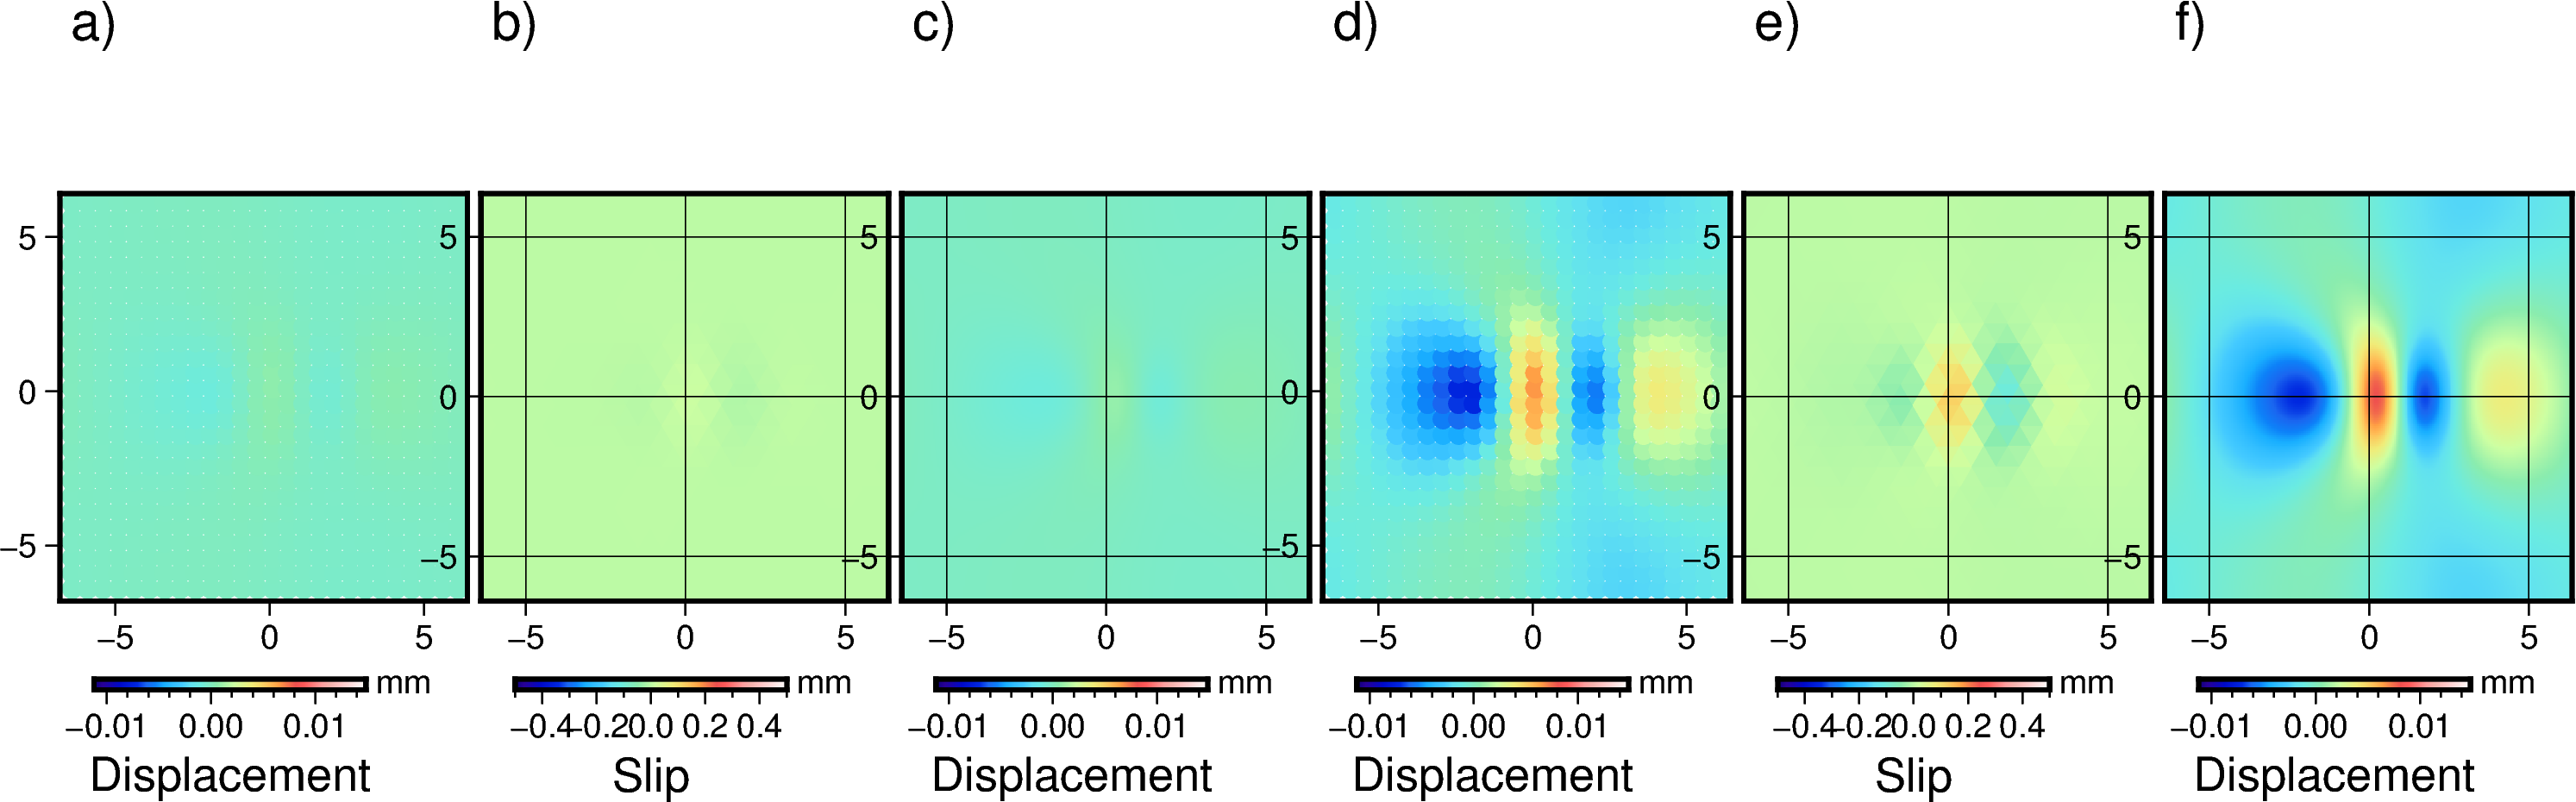

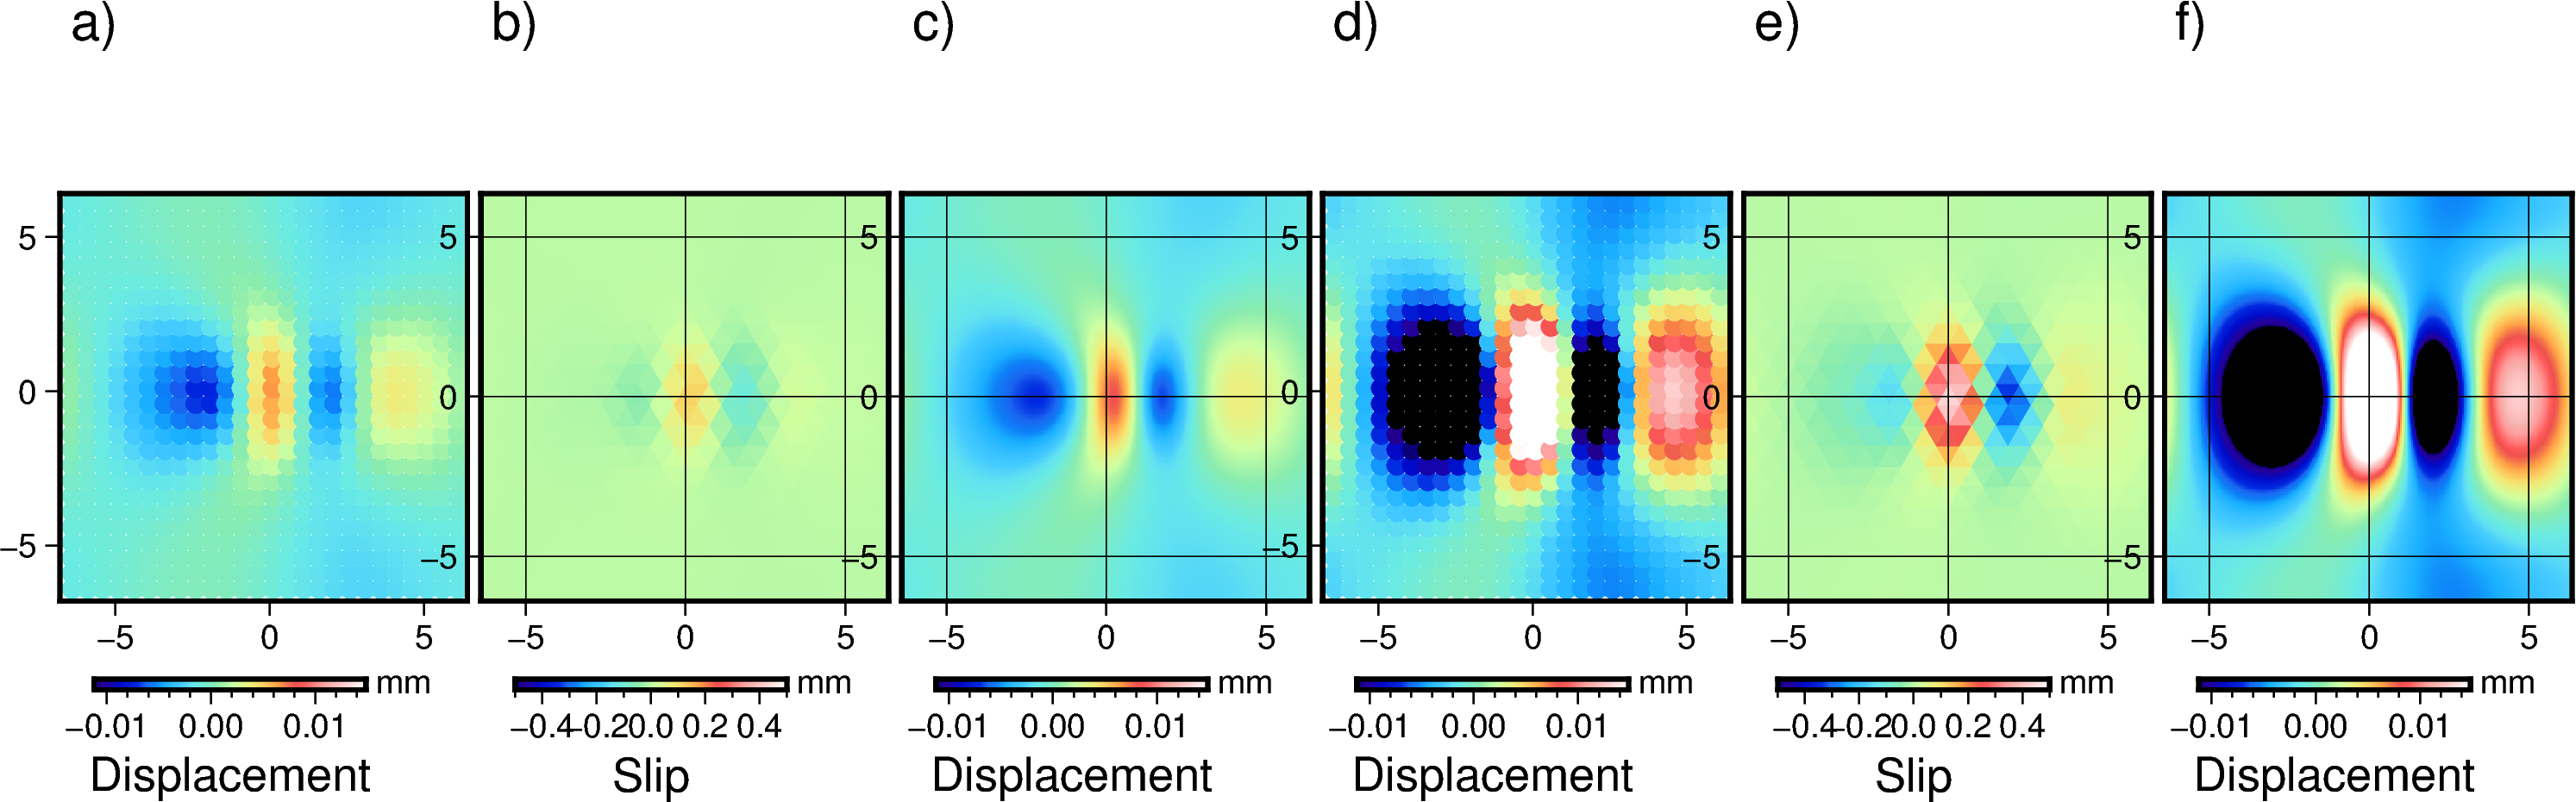

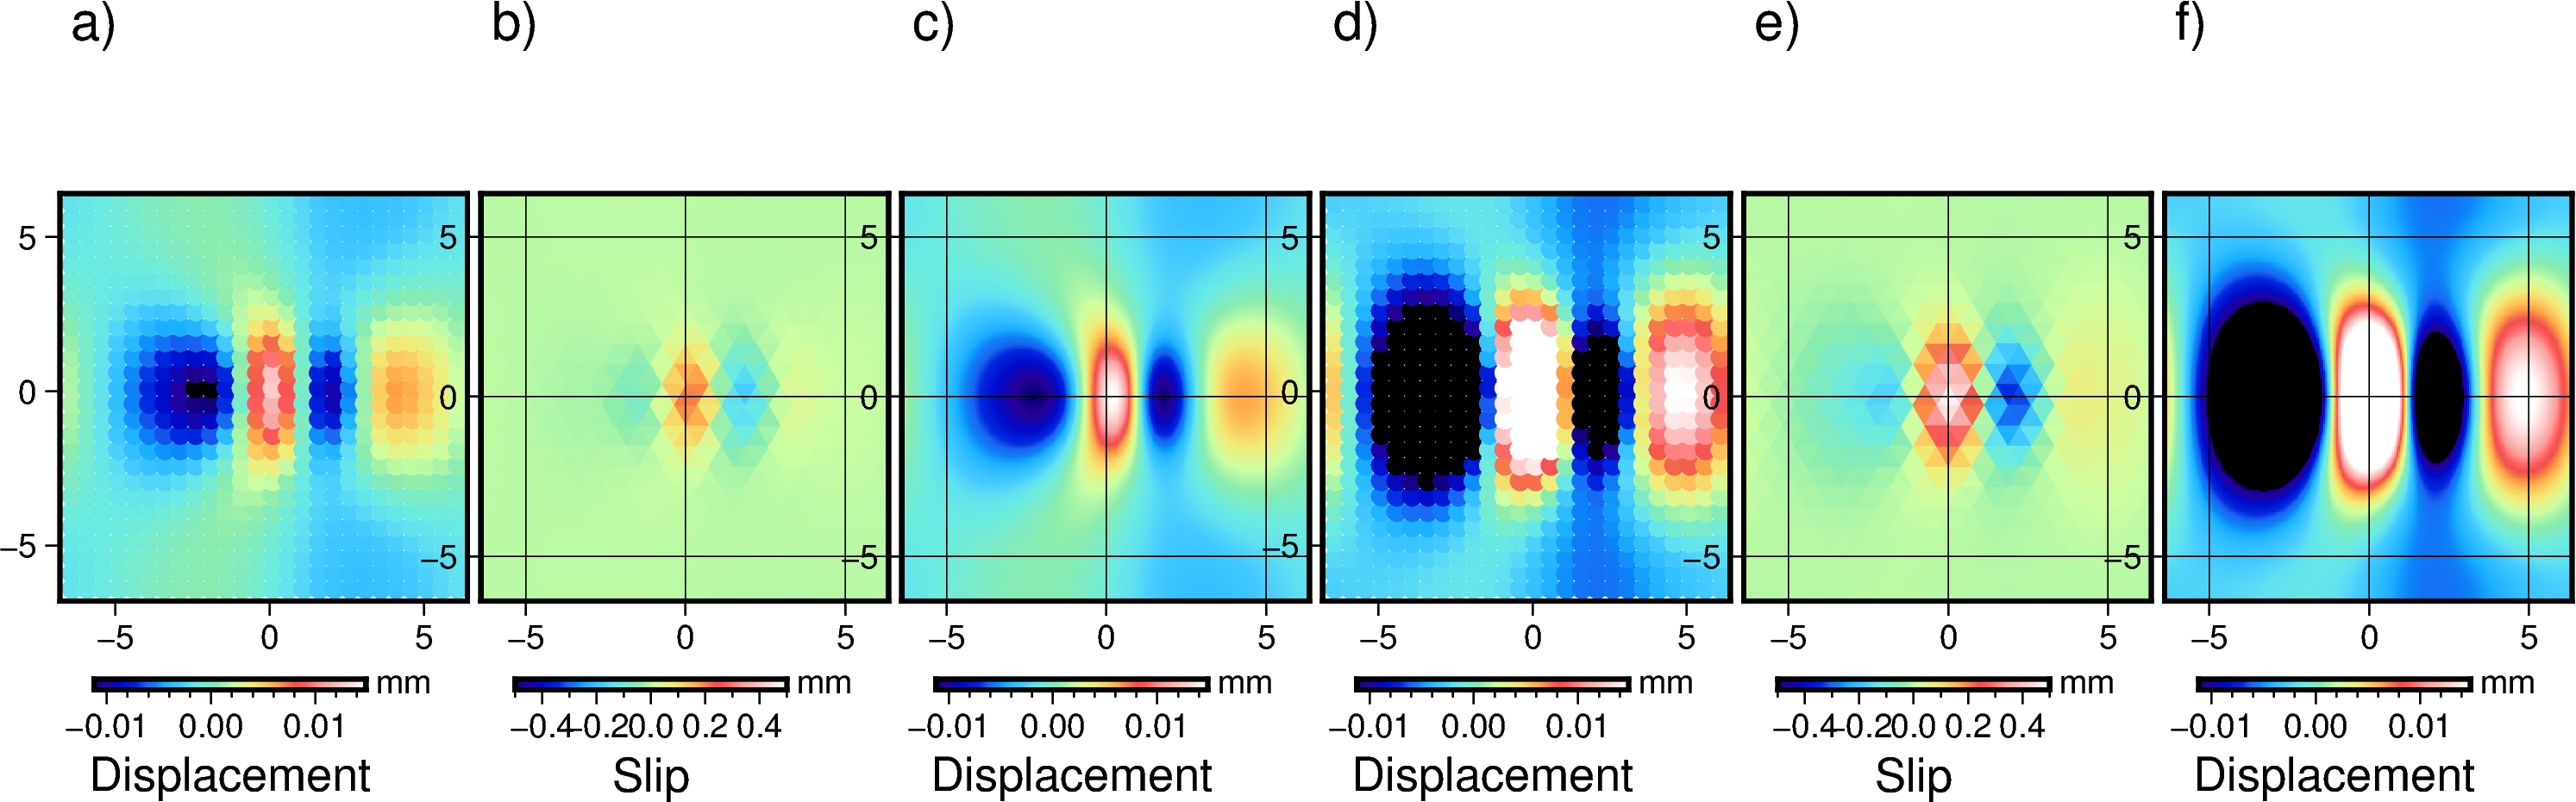

In [9]:
import xarray as xa 

# Specify parameters to be plotted 
dip_idx = np.array([1, 1])
dep_idx = np.array([1, 1])
smo_idx = np.array([1, 1])
vis_idx = np.array([0, 2])


sel_times = np.array([1, 10, 20])

# File and directory names
sh_name0 = 'dip{:}_z{:}_eta{:0.2}.sh'.format(dips[dip_idx[0]], depth_mults[dep_idx[0]], viscosities[vis_idx[0]])
directory0 = f"./tutorials/parameter_ranges/output_{sh_name0[:-3]}".format()
time_vector0 = np.loadtxt(directory0 + "/time.txt", unpack=False)
sel_times_idx0 = np.nonzero(np.isin(time_vector0, sel_times))[0]

sh_name1 = 'dip{:}_z{:}_eta{:0.2}.sh'.format(dips[dip_idx[1]], depth_mults[dep_idx[1]], viscosities[vis_idx[1]])
directory1 = f"./tutorials/parameter_ranges/output_{sh_name1[:-3]}".format()
time_vector1 = np.loadtxt(directory1 + "/time.txt", unpack=False)
sel_times_idx1 = np.nonzero(np.isin(time_vector1, sel_times))[0]


# List of east displacement grd files 
e_disp_file_list0 = sorted(glob.glob(directory0 + "/*-relax-east.grd"))
e_disp_file_list1 = sorted(glob.glob(directory1 + "/*-relax-east.grd"))

# Get z limits from grdinfo. It's okay that this is from a single file; will be close enough for all
info = pygmt.grdinfo(e_disp_file_list0[sel_times_idx0[-1]], nearest_multiple="+a0.01")

# Model numbers for inversion results
mod_num0 = (len(depth_mults) * len(smooths) * len(viscosities))*dip_idx[0] + (len(smooths) * len(viscosities))*dep_idx[0] + (len(viscosities))*smo_idx[0] + vis_idx[0]
mod_num1 = (len(depth_mults) * len(smooths) * len(viscosities))*dip_idx[1] + (len(smooths) * len(viscosities))*dep_idx[1] + (len(viscosities))*smo_idx[1] + vis_idx[1]
# mod_num0 = (len(dips)-1 + len(depth_mults)-1 + len(smooths)-1 + len(viscosities)-1)*dip_idx[0] 
# mod_num1 = (len(dips)-1)*dip_idx[1]+dip_idx[1] + (len(depth_mults)-1)*dep_idx[1]+dep_idx[1] + (len(smooths)-1)*smo_idx[1]+smo_idx[1] + vis_idx[1]

# For all time steps,
# for i in range(len(e_disp_file_list)):
for i in range(len(sel_times_idx)):
    # Convert predicted displacements to xarrays
    # eastdispg0 = xa.DataArray.copy(grid)
    # eastdispg0.values = np.reshape(pred_disp[0::3, sel_times_idx0[i], mod_num0], (256, 256))
    # eastdispg1 = xa.DataArray.copy(grid)
    # eastdispg1.values = np.reshape(pred_disp[0::3, sel_times_idx1[i], mod_num1], (256, 256))

    fid0 = open("meshes0.txt", "w")
    fid1 = open("meshes1.txt", "w")
    for j in range(len(meshes[1].verts)):
      line0 = "> -Z{}\n{}, {}\n{}, {}\n{}, {}\n".format(-est_slip[3*n_source_tri+3*j+1, sel_times_idx0[i], mod_num0],
         meshes[1].coords[meshes[1].verts[j, 0], 0],
         meshes[1].coords[meshes[1].verts[j, 0], 1],
         meshes[1].coords[meshes[1].verts[j, 1], 0],
         meshes[1].coords[meshes[1].verts[j, 1], 1],
         meshes[1].coords[meshes[1].verts[j, 2], 0],
         meshes[1].coords[meshes[1].verts[j, 2], 1])
      line1 = "> -Z{}\n{}, {}\n{}, {}\n{}, {}\n".format(-est_slip[3*n_source_tri+3*j+1, sel_times_idx1[i], mod_num1],
         meshes[1].coords[meshes[1].verts[j, 0], 0],
         meshes[1].coords[meshes[1].verts[j, 0], 1],
         meshes[1].coords[meshes[1].verts[j, 1], 0],
         meshes[1].coords[meshes[1].verts[j, 1], 1],
         meshes[1].coords[meshes[1].verts[j, 2], 0],
         meshes[1].coords[meshes[1].verts[j, 2], 1])
      fid0.write(line0)
      fid1.write(line1)
    fid0.close()
    fid1.close()

    # pyGMT figure
    # fig = pygmt.Figure()
    # # pygmt.makecpt(cmap="haxby", series=[-1.2, 1.2])
    # pygmt.makecpt(cmap="haxby", series=[-10, 10])
    # # TDE estimated slip
    # fig.plot("meshes.txt", close=True, cmap=True, region=[min(xg), max(xg), min(yg), max(yg)], projection="X10c", frame=["ag"])
    # fig.colorbar(frame=["x+lSlip", "y+lmm"])
    # fig.show()

    # Read in Relax displacements
    e_disp0 = pygmt.load_dataarray(e_disp_file_list0[sel_times_idx0[i]])
    e_disp1 = pygmt.load_dataarray(e_disp_file_list1[sel_times_idx1[i]])

    slip_scale = .5
    projname = "X4c"

    # pyGMT figure: 2 panels, TDE and Relax
    fig = pygmt.Figure()
    
    with fig.subplot(nrows=1, ncols=6, figsize=("24c", "6c"), autolabel=True):
         with fig.set_panel(panel=0):
             # TDE predictions
            #  fig.grdimage(grid=northdispg, projection="X10c", frame=["ag", f"+tTDE, step {i}"])
             pygmt.makecpt(cmap="haxby", series=info[2:])
            #  fig.grdimage(grid=eastdispg0, projection="X5c", frame="ag")
             fig.plot(x=obsg[:, 0], y=obsg[:, 1], color=pred_disp[0::3, sel_times_idx0[i], mod_num0], cmap=True, style="c0.2c", projection=projname, frame="ag")
             fig.colorbar(frame=["x+lDisplacement", "y+lmm"])
         with fig.set_panel(panel=1):
             pygmt.makecpt(cmap="haxby", series=[-slip_scale, slip_scale])
             # TDE estimated slip
             fig.plot("meshes0.txt", close=True, cmap=True, region=[min(xg), max(xg), min(yg), max(yg)], projection=projname, frame=["ag"])
             fig.colorbar(frame=["x+lSlip", "y+lmm"])         
         with fig.set_panel(panel=2):
             # Relax grid
            #  fig.grdimage(grid=n_disp, projection="X10c", frame=["ag", f"+tRelax, step {i}"])
             pygmt.makecpt(cmap="haxby", series=info[2:])
             fig.grdimage(grid=e_disp0, projection=projname, frame="ag")
             fig.colorbar(frame=["x+lDisplacement", "y+lmm"])

         with fig.set_panel(panel=3):
             # TDE predictions
            #  fig.grdimage(grid=northdispg, projection="X10c", frame=["ag", f"+tTDE, step {i}"])
             pygmt.makecpt(cmap="haxby", series=info[2:])
            #  fig.grdimage(grid=eastdispg1, projection="X5c", frame="ag")
             fig.plot(x=obsg[:, 0], y=obsg[:, 1], color=pred_disp[0::3, sel_times_idx1[i], mod_num1], cmap=True, style="c0.2c", projection=projname, frame="ag")
             fig.colorbar(frame=["x+lDisplacement", "y+lmm"])
         with fig.set_panel(panel=4):
             pygmt.makecpt(cmap="haxby", series=[-slip_scale, slip_scale])
             # TDE estimated slip
             fig.plot("meshes1.txt", close=True, cmap=True, region=[min(xg), max(xg), min(yg), max(yg)], projection=projname, frame=["ag"])
             fig.colorbar(frame=["x+lSlip", "y+lmm"])  
         with fig.set_panel(panel=5):
             # Relax grid
            #  fig.grdimage(grid=n_disp, projection="X10c", frame=["ag", f"+tRelax, step {i}"])
             pygmt.makecpt(cmap="haxby", series=info[2:])
             fig.grdimage(grid=e_disp1, projection=projname, frame="ag")
             fig.colorbar(frame=["x+lDisplacement", "y+lmm"])

    fig.show()
    # fig.savefig(f"png/ndisplacement_{i}.png")

### Basal slip distribution (matplotlib)

In [ ]:
# Plot a single mesh; modified from celeri_vis.py
def plot_mesh(mesh, fill_value, ax):
    x_coords = mesh.coords[:, 0]
    y_coords = mesh.coords[:, 1]
    vertex_array = np.asarray(mesh.verts)

    if not ax:
        ax = plt.gca()
    xy = np.c_[x_coords, y_coords]
    verts = xy[vertex_array]
    pc = matplotlib.collections.PolyCollection(
        verts, edgecolor="none", cmap="rainbow"
    )
    pc.set_array(fill_value)
    ax.add_collection(pc)
    ax.autoscale()
    pc.set_clim([-0.02, 0.02])
    plt.colorbar(pc, label="Strike-slip (N-S)")

### Plot for each time step

In [ ]:
plt.close("all")
for i in range(len(n_disp_file_list)):
    fig, ax = plt.subplots()
    plot_mesh(meshes[1], -est_slip[3*nsource_tri+1::3, i], ax)
    ax.plot([-7, 7, 7, -7, -7], [-7, -7, 7, 7, -7], 'k')
    ax.set_title(f"Time step {i}")
    # fig.savefig(f"png/horizslip_{i}.png")

### Displacement vs. time at selected points

In [ ]:
# Get target coordinates
c1 = [2.5, 0]
c2 = [2.5, 5]
# Coordinate indices
grididx1 = np.where((obsg_full[:, 0]==c1[0]) & (obsg_full[:, 1]==c1[1]))[0]
grididx2 = np.where((obsg_full[:, 0]==c2[0]) & (obsg_full[:, 1]==c2[1]))[0]
# Observed and predicted displacements
obsdisp1 = e_disp_array[grididx1, :]
obsdisp2 = e_disp_array[grididx2, :]
preddisp1 = pred_disp[3*grididx1, :]
preddisp2 = pred_disp[3*grididx2, :]
print((preddisp1[0, -1]-obsdisp1[0, -1])/obsdisp1[0, -1])
print((preddisp2[0, -1]-obsdisp2[0, -1])/obsdisp2[0, -1])

# Find element centroid nearest target coordinates
horiz_centroids = np.mean(horiz_tri_pts, axis=1)
dist1 = np.sqrt((horiz_centroids[:, 0] - c1[0])**2 + (horiz_centroids[:, 1] - c1[1])**2)
dist2 = np.sqrt((horiz_centroids[:, 0] - c2[0])**2 + (horiz_centroids[:, 1] - c2[1])**2)
el_idx1 = np.argmin(dist1)
el_idx2 = np.argmin(dist2)
slip1 = est_slip[3*(nsource_tri+el_idx1)+1, :]
slip2 = est_slip[3*(nsource_tri+el_idx2)+1, :]

# Set up figure
fig, ax1 = plt.subplots(1, 1, sharex=True, figsize=(7, 4))
ax1.plot(time_vector, obsdisp1[0, :], 'b', label="(2.5, 0) Relax")
ax1.plot(time_vector, preddisp1[0, :], 'b--', label="(2.5, 0) TDE")
ax1.plot(time_vector, obsdisp2[0, :], 'r', label="(2.5, 5) Relax")
ax1.plot(time_vector, preddisp2[0, :], 'r--', label="(2.5, 5) TDE")
ax1.legend()
ax1.set_xlabel('Time')
ax1.set_ylabel('East displacement')
ax1.set_title("Total displacement")
# axr = ax1.twinx()
# axr.plot(time_vector, slip1, 'b--', linewidth=3)
# axr.plot(time_vector, slip2, 'r--', linewidth=3)
# axr.set_ylabel('Dip-slip')

# fig.savefig(f"png/timeseries.png")

### Show Relax vs. TDE displacements at different horizons

In [ ]:
other_depth1 = 2
other_depth2 = 10

other_directory1 = directory + "_" + str(other_depth1) + "km"
other_directory2 = directory + "_" + str(other_depth2) + "km"

# Read sequence of displacement grd files 
e_disp_file_list1 = sorted(glob.glob(other_directory1 + "/*-relax-east.grd"))
n_disp_file_list1 = sorted(glob.glob(other_directory1 + "/*-relax-north.grd"))
u_disp_file_list1 = sorted(glob.glob(other_directory1 + "/*-relax-up.grd"))

# Read sequence of displacement grd files 
e_disp_file_list2 = sorted(glob.glob(other_directory2 + "/*-relax-east.grd"))
n_disp_file_list2 = sorted(glob.glob(other_directory2 + "/*-relax-north.grd"))
u_disp_file_list2 = sorted(glob.glob(other_directory2 + "/*-relax-up.grd"))

# Get z limits from grdinfo
info1 = pygmt.grdinfo(e_disp_file_list1[-1], nearest_multiple="+a0.01")
info2 = pygmt.grdinfo(e_disp_file_list2[-1], nearest_multiple="+a0.01")

# Allocate space for estimated slip and predicted displacements
pred_disp1 = np.zeros((obsg_full.size, len(e_disp_file_list1)))
pred_disp2 = np.zeros((obsg_full.size, len(e_disp_file_list2)))

# Calculate partials for other depths
obsg_full1 = np.array([Xg, Yg, -(other_depth1-0.1)*np.ones_like(Yg)]).reshape((3, -1)).T.copy()
disp_mat_full1 = cutde_halfspace.disp_matrix(obs_pts=obsg_full1, tris=horiz_tri_pts, nu=0.25)
obsg_full2 = np.array([Xg, Yg, -other_depth2*np.ones_like(Yg)]).reshape((3, -1)).T.copy()
disp_mat_full2 = cutde_halfspace.disp_matrix(obs_pts=obsg_full2, tris=horiz_tri_pts, nu=0.25)

# Selected time steps
sel_times = [20, 30, 70]

# Predict displacements at each step 
# for i in range(len(e_disp_file_list)):
for i in sel_times:
    # Read Relax displacement components
    e_disp1 = pygmt.load_dataarray(e_disp_file_list1[i])
    n_disp1 = pygmt.load_dataarray(n_disp_file_list1[i])
    u_disp1 = pygmt.load_dataarray(u_disp_file_list1[i])
    e_disp2 = pygmt.load_dataarray(e_disp_file_list2[i])
    n_disp2 = pygmt.load_dataarray(n_disp_file_list2[i])
    u_disp2 = pygmt.load_dataarray(u_disp_file_list2[i])
    
    # Predict displacements at the full grid resolution at alternate depths 
    pred_disp1[:, i] = disp_mat_full1.reshape((-1, 3*ntri)).dot(est_slip[:, i])
    pred_disp2[:, i] = disp_mat_full2.reshape((-1, 3*ntri)).dot(est_slip[:, i])
    
    # Convert to grids
    eastdispg1 = xa.DataArray.copy(grid)
    eastdispg1.values = np.reshape(pred_disp1[0::3, i], (256, 256))
    northdispg1 = xa.DataArray.copy(grid)
    northdispg1.values = np.reshape(pred_disp1[1::3, i], (256, 256))
    updispg1 = xa.DataArray.copy(grid)
    updispg1.values = np.reshape(pred_disp1[2::3, i], (256, 256))

    eastdispg2 = xa.DataArray.copy(grid)
    eastdispg2.values = np.reshape(pred_disp2[0::3, i], (256, 256))
    northdispg2 = xa.DataArray.copy(grid)
    northdispg2.values = np.reshape(pred_disp2[1::3, i], (256, 256))
    updispg2 = xa.DataArray.copy(grid)
    updispg2.values = np.reshape(pred_disp2[2::3, i], (256, 256))

    # pyGMT figure: 2 panels, TDE and Relax
    fig = pygmt.Figure()
    pygmt.makecpt(cmap="haxby", series=info1[2:])
    with fig.subplot(nrows=1, ncols=2, figsize=("22c", "6c")):
         with fig.set_panel(panel=0):
             # TDE predictions
             fig.grdimage(grid=eastdispg1, projection="X10c", frame=["ag"])
             fig.colorbar(frame=["x+lDisplacement", "y+lmm"])
         with fig.set_panel(panel=1):
             # Relax grid
             fig.grdimage(grid=e_disp1, projection="X10c", frame=["ag"])
             fig.colorbar(frame=["x+lDisplacement", "y+lmm"])

    fig.show()

    fig = pygmt.Figure()
    with fig.subplot(nrows=1, ncols=2, figsize=("22c", "6c")):
         with fig.set_panel(panel=0):
            # TDE predictions
             pygmt.makecpt(cmap="haxby", series='-0.0002/0.0002')
             fig.grdimage(grid=eastdispg2, projection="X10c", frame=["ag"])
             fig.colorbar(frame=["x+lDisplacement", "y+lmm"])
         with fig.set_panel(panel=1):
             # Relax grid
             pygmt.makecpt(cmap="haxby", series=info2[2:])
             fig.grdimage(grid=e_disp2, projection="X10c", frame=["ag"])
             fig.colorbar(frame=["x+lDisplacement", "y+lmm"])

    fig.show()

print(np.max(e_disp2))
print(np.max(eastdispg2))

### Plots showing actual TDE slip vs. Relax displacements

In [ ]:
import pandas as pd 
# Predict displacements at each step 
# for i in range(len(e_disp_file_list)):
for i in sel_times:
    
    # Read Relax displacement components
    e_disp1 = pygmt.load_dataarray(e_disp_file_list1[i])
    n_disp1 = pygmt.load_dataarray(n_disp_file_list1[i])
    u_disp1 = pygmt.load_dataarray(u_disp_file_list1[i])

    # Write mesh slip file
    fid = open("meshes.txt", "w")
    for j in range(len(meshes[1].verts)):
      line = "> -Z{}\n{}, {}\n{}, {}\n{}, {}\n".format(-est_slip[3*nsource_tri+3*j+1, i],
         meshes[1].coords[meshes[1].verts[j, 0], 0],
         meshes[1].coords[meshes[1].verts[j, 0], 1],
         meshes[1].coords[meshes[1].verts[j, 1], 0],
         meshes[1].coords[meshes[1].verts[j, 1], 1],
         meshes[1].coords[meshes[1].verts[j, 2], 0],
         meshes[1].coords[meshes[1].verts[j, 2], 1])
      fid.write(line)
    fid.close()

    # pyGMT figure: 2 panels, TDE and Relax
    fig = pygmt.Figure()
    pygmt.makecpt(cmap="haxby", series=info1[2:])
    with fig.subplot(nrows=1, ncols=2, figsize=("22c", "6c")):
         with fig.set_panel(panel=0):
            # TDE estimated slip
            fig.plot("meshes.txt", close=True, cmap=True, region=[min(xg), max(xg), min(yg), max(yg)], projection="X10c", frame=["ag"])
            fig.colorbar(frame=["x+lSlip", "y+lmm"])
         with fig.set_panel(panel=1):
            # Relax grid
            fig.grdimage(grid=e_disp1, projection="X10c", frame=["ag"])
            fig.colorbar(frame=["x+lDisplacement", "y+lmm"])


    fig.show()

## Slip profiles

- 3 panels, each showing one parameter variation at `time = 10 y`
- Panel 1: 3 dips, depth = 2, visc = 1
- Panel 2: 20º dip, 3 depths, visc = 1
- Panel 3: 20º dip, depth = 2, 3 viscs

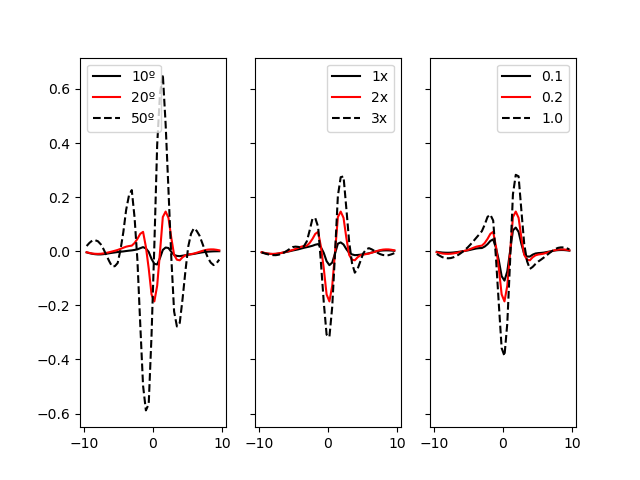

In [34]:
from scipy.interpolate import LinearNDInterpolator
from scipy.signal import find_peaks, peak_widths

plt.close("all")
# Define profile across middle of mesh
horiz_centroids = np.mean(horiz_tri_pts, axis=1)
xprofile = np.linspace(-10, 10)
yprofile = 0*xprofile
fig, (dipax, depax, visax) = plt.subplots(1, 3, sharey=True)

sel_times = 10

###########
# Dip panel
###########
dip_idx = np.array([0, 1, 4])
dep_idx = 1
smo_idx = 1
vis_idx = 1

these_lines = ['k', 'r', 'k--']

for i in range(len(dip_idx)):
    # File and directory names
    sh_name0 = 'dip{:}_z{:}_eta{:0.2}.sh'.format(dips[dip_idx[i]], depth_mults[dep_idx], viscosities[vis_idx])
    directory0 = f"./tutorials/parameter_ranges/output_{sh_name0[:-3]}".format()
    time_vector0 = np.loadtxt(directory0 + "/time.txt", unpack=False)
    sel_times_idx0 = np.nonzero(np.isin(time_vector0, sel_times))[0]
    # Model numbers for inversion results
    mod_num0 = (len(depth_mults) * len(smooths) * len(viscosities))*dip_idx[i] + (len(smooths) * len(viscosities))*dep_idx + (len(viscosities))*smo_idx + vis_idx

    # Interpolate dip slip
    interp = LinearNDInterpolator(list(zip(horiz_centroids[:, 0], horiz_centroids[:, 1])), est_slip[3*n_source_tri+1::3, sel_times_idx0, mod_num0])
    interp_slip = interp(xprofile, yprofile)
    dipax.plot(xprofile, interp_slip, these_lines[i])
    dipax.legend(['10º', '20º', '50º'])

#############
# Depth panel
#############
dip_idx = 1
dep_idx = [0, 1, 2]
smo_idx = 1
vis_idx = 1

for i in range(len(dep_idx)):
    # File and directory names
    sh_name0 = 'dip{:}_z{:}_eta{:0.2}.sh'.format(dips[dip_idx], depth_mults[dep_idx[i]], viscosities[vis_idx])
    directory0 = f"./tutorials/parameter_ranges/output_{sh_name0[:-3]}".format()
    time_vector0 = np.loadtxt(directory0 + "/time.txt", unpack=False)
    sel_times_idx0 = np.nonzero(np.isin(time_vector0, sel_times))[0]
    # Model numbers for inversion results
    mod_num0 = (len(depth_mults) * len(smooths) * len(viscosities))*dip_idx + (len(smooths) * len(viscosities))*dep_idx[i] + (len(viscosities))*smo_idx + vis_idx

    # Interpolate dip slip
    interp = LinearNDInterpolator(list(zip(horiz_centroids[:, 0], horiz_centroids[:, 1])), est_slip[3*n_source_tri+1::3, sel_times_idx0, mod_num0])
    interp_slip = interp(xprofile, yprofile)
    depax.plot(xprofile, interp_slip, these_lines[i])
    depax.legend(['1x', '2x', '3x'])


#################
# Viscosity panel
#################
dip_idx = 1
dep_idx = 1
smo_idx = 1
vis_idx = [0, 1, 2]

for i in range(len(vis_idx)):
    # File and directory names
    sh_name0 = 'dip{:}_z{:}_eta{:0.2}.sh'.format(dips[dip_idx], depth_mults[dep_idx], viscosities[vis_idx[i]])
    directory0 = f"./tutorials/parameter_ranges/output_{sh_name0[:-3]}".format()
    time_vector0 = np.loadtxt(directory0 + "/time.txt", unpack=False)
    sel_times_idx0 = np.nonzero(np.isin(time_vector0, sel_times))[0]
    # Model numbers for inversion results
    mod_num0 = (len(depth_mults) * len(smooths) * len(viscosities))*dip_idx + (len(smooths) * len(viscosities))*dep_idx + (len(viscosities))*smo_idx + vis_idx[i]

    # Interpolate dip slip
    interp = LinearNDInterpolator(list(zip(horiz_centroids[:, 0], horiz_centroids[:, 1])), est_slip[3*n_source_tri+1::3, sel_times_idx0, mod_num0])
    interp_slip = interp(xprofile, yprofile)
    visax.plot(xprofile, interp_slip, these_lines[i])
    visax.legend(['0.1', '0.2', '1.0'])



# Wavelength of estimated slip

Interpolate slip at `y=0` and look at profile. Calculate full-width half-max. 

In [ ]:
from scipy.interpolate import LinearNDInterpolator
from scipy.signal import find_peaks, peak_widths

plt.close("all")
# Define profile across middle of mesh
xprofile = np.linspace(-10, 10)
yprofile = 0*xprofile
fig, ax = plt.subplots()

peakpeak = np.zeros(len(time_vector))
peakpeakwidth = np.zeros(len(time_vector))

for i in range(1,len(time_vector)):
    # Interpolate dip slip
    interp = LinearNDInterpolator(list(zip(horiz_centroids[:, 0], horiz_centroids[:, 1])), est_slip[1::3, i, mod_num])
    interp_slip = interp(xprofile, yprofile)
    # Find peaks of interpolated slip
    peaks_pos, _ = find_peaks(interp_slip, 0)
    peaks_neg, _ = find_peaks(-interp_slip, 0)
    peaks = np.concatenate((peaks_pos, peaks_neg))
    # Find peak widths
    fwhm = peak_widths(interp_slip, peaks, rel_height=0.5)
    peakpeak = np.argmax(interp_slip[peaks])
    peakpeakwidth[i] = fwhm[0][peakpeak]
    # ax.plot(interp_slip)
    # ax.plot(peaks, interp_slip[peaks], "x")
    # ax.hlines(*fwhm[1:], color="red")

ax.plot(time_vector[1:], peakpeakwidth[1:], '.')

# Parameter sweep plots

In [ ]:
from scipy.interpolate import LinearNDInterpolator
from scipy.signal import find_peaks, peak_widths

plt.close("all")

# Define a subset of years. Find the index for each run closest to these years
sel_years = [1, 5, 10, 20]

# Define profile across middle of mesh
xprofile = np.linspace(-10, 10)
xdiff = xprofile[1] - xprofile[0]
yprofile = 0*xprofile
fig, ax = plt.subplots()

# List of dips to test
dips = np.arange(10, 60, 10)
# dips = np.arange(10, 20, 10)

# List of depth multipliers: 
# Fault depth will be calculated, then multiplied by depth multiplier to define thickness of elastic layer
depth_mults = np.arange(1, 4, 1).astype(float)
# depth_mults = np.arange(1, 2, 1).astype(float)

# List of viscosities to test
# Framed as gammadot = 1/Maxwell time
maxwell_times = np.array([10, 5, 1])
# maxwell_times = np.array([10])
viscosities = 1./maxwell_times

n_trials = len(dips)*len(depth_mults)*len(viscosities)
time_vectors = np.zeros((500, n_trials))

interp_slip = np.zeros((len(xprofile), 500, n_trials))

# Allocate space for arrays that will hold peak widths near source fault for 3 selected times
all_peak_widths1 = np.zeros((len(dips), len(depth_mults), len(viscosities)))
all_peak_widths10 = np.zeros((len(dips), len(depth_mults), len(viscosities)))
all_peak_widths20 = np.zeros((len(dips), len(depth_mults), len(viscosities)))

# Total index counting
totalidx = -1
idx_matrix = np.zeros((n_trials, 4))
# For each trial, 
for dipi in range(len(dips)):
    for depthi in range(len(depth_mults)):
        for visci in range(len(viscosities)):
            totalidx += 1
            idx_matrix[totalidx, :] = [totalidx, dipi, depthi, visci]
            sh_name = 'dip{:}_z{:}_eta{:0.2}.sh'.format(dips[dipi], depth_mults[depthi], viscosities[visci])
            directory = f"./tutorials/parameter_ranges/output_{sh_name[:-3]}".format()
            time_vector = np.loadtxt(directory + "/time.txt", unpack=False)
            time_vectors[0:len(time_vector), totalidx] = time_vector
            time_idx = np.in1d(time_vector, [1, 10, 20]).nonzero()[0]

            peakpeak = np.zeros(len(time_vector))
            meanpeakwidth = np.zeros(len(time_vector))
            peakpeakwidth = np.zeros(len(time_vector))
            peakclosewidth = np.zeros(len(time_vector))

            for i in range(1,len(time_vector)):
                # Interpolate dip slip
                interp = LinearNDInterpolator(list(zip(horiz_centroids[:, 0], horiz_centroids[:, 1])), est_slip[1::3, i, totalidx])
                interp_slip[:, i, totalidx] = interp(xprofile, yprofile)
                # Find peaks of interpolated slip
                peaks_pos, _ = find_peaks(interp_slip[:, i, totalidx], 0)
                peaks_neg, _ = find_peaks(-interp_slip[:, i, totalidx], 0)
                peaks = np.concatenate((peaks_pos, peaks_neg))
                # Find peak widths
                fwhm_pos = peak_widths(interp_slip[:, i, totalidx], peaks_pos, rel_height=0.5)
                fwhm_neg = peak_widths(-interp_slip[:, i, totalidx], peaks_neg, rel_height=0.5)
                fwhm = np.concatenate((fwhm_pos[0], fwhm_neg[0]))
                # Find biggest peak and its width
                peakpeak = np.argmax(interp_slip[peaks, i, totalidx])
                peakpeakwidth[i] = xdiff*fwhm[peakpeak]
                # Mean peak width
                meanpeakwidth[i] = xdiff*np.mean(fwhm)
                # Find peak closest to source fault. Just doing this manually for now by finding value closest to x = 1
                peakclose = np.argmin(np.abs(xprofile[peaks]-3))
                peakclosewidth[i] = xdiff*fwhm[peakclose]

                
                # ax.plot(interp_slip)
                # ax.plot(peaks, interp_slip[peaks], "x")
                # ax.hlines(*fwhm[1:], color="red")

            ax.plot(time_vector[1:], peakclosewidth[1:])
            # ax.plot(time_vector[1:], meanpeakwidth[1:])
            
            # ax.plot(time_vector[1:], np.sum(np.abs(est_slip[1::3, 1:len(time_vector), totalidx]), axis=0))

### Separating peak width plots by parameter

In [ ]:
plt.close("all")
fig, ax = plt.subplots()

# Define a subset of years. Find the index for each run closest to these years
sel_years = [1, 10, 20]

# Define profile across middle of mesh
xprofile = np.linspace(-10, 10)
xdiff = xprofile[1] - xprofile[0]
yprofile = 0*xprofile

# List of dips to test
dips = np.arange(10, 60, 10)
# dips = np.arange(10, 20, 10)

# List of depth multipliers: 
# Fault depth will be calculated, then multiplied by depth multiplier to define thickness of elastic layer
depth_mults = np.arange(1, 4, 1).astype(float)
# depth_mults = np.arange(1, 2, 1).astype(float)

# List of viscosities to test
# Framed as gammadot = 1/Maxwell time
maxwell_times = np.array([10, 5, 1])
viscosities = 1./maxwell_times

n_trials = len(dips)*len(depth_mults)*len(viscosities)
time_vectors = np.zeros((500, n_trials))

interp_slip = np.zeros((len(xprofile), 500, n_trials))

# Allocate space for arrays that will hold peak widths near source fault for 3 selected times
all_peak_widths = np.zeros((len(dips), len(depth_mults), len(viscosities), 3))

# For each trial, 
totalidx = -1
for dipi in range(len(dips)):
    for depthi in range(len(depth_mults)):
        for visci in range(len(viscosities)):
            totalidx += 1
            sh_name = 'dip{:}_z{:}_eta{:0.2}.sh'.format(dips[dipi], depth_mults[depthi], viscosities[visci])
            directory = f"./tutorials/parameter_ranges/output_{sh_name[:-3]}".format()
            time_vector = np.loadtxt(directory + "/time.txt", unpack=False)
            time_vectors[0:len(time_vector), totalidx] = time_vector
            time_idx = np.in1d(time_vector, sel_years).nonzero()[0]
            
            peakpeak = np.zeros(len(time_vector))
            meanpeakwidth = np.zeros(len(time_vector))
            peakpeakwidth = np.zeros(len(time_vector))
            peakclosewidth = np.zeros(len(time_vector))

            for i in range(0,len(time_idx)):
                # Interpolate dip slip
                interp = LinearNDInterpolator(list(zip(horiz_centroids[:, 0], horiz_centroids[:, 1])), est_slip[1::3, time_idx[i], totalidx])
                interp_slip[:, i, totalidx] = interp(xprofile, yprofile)
                # Find peaks of interpolated slip
                peaks_pos, _ = find_peaks(interp_slip[:, i, totalidx], 0)
                peaks_neg, _ = find_peaks(-interp_slip[:, i, totalidx], 0)
                peaks = np.concatenate((peaks_pos, peaks_neg))
                # Find peak widths
                fwhm_pos = peak_widths(interp_slip[:, i, totalidx], peaks_pos, rel_height=0.5)
                fwhm_neg = peak_widths(-interp_slip[:, i, totalidx], peaks_neg, rel_height=0.5)
                fwhm = np.concatenate((fwhm_pos[0], fwhm_neg[0]))
                # Find biggest peak and its width
                peakpeak = np.argmax(interp_slip[peaks, i, totalidx])
                peakpeakwidth[i] = xdiff*fwhm[peakpeak]
                # Mean peak width
                meanpeakwidth[i] = xdiff*np.mean(fwhm)
                # Find peak closest to source fault. Just doing this manually for now
                peakclose = np.argmin(np.abs(xprofile[peaks]-3))
                all_peak_widths[dipi, depthi, visci, i] = xdiff*fwhm[peakclose]

                
                # ax.plot(interp_slip)
                # ax.plot(peaks, interp_slip[peaks], "x")
                # ax.hlines(*fwhm[1:], color="red")

            # ax.plot(time_vector[1:], peakclosewidth[1:])
            ax.plot(time_vector[1:], meanpeakwidth[1:])
            # ax.plot(time_vector[1:], np.sum(np.abs(est_slip[1::3, 1:len(time_vector), totalidx]), axis=0))


In [ ]:
plt.close('all')
figp, axp = plt.subplots()
thisdip = [0, 0]
thisdepth = [0, 0]
thisvisc = [1, 2]
thisidx0 = np.where((idx_matrix[:, 1:] == np.hstack((thisdip[0], thisdepth[0], thisvisc[0]))).all(axis=1))[0]
thisidx1 = np.where((idx_matrix[:, 1:] == np.hstack((thisdip[1], thisdepth[1], thisvisc[1]))).all(axis=1))[0]
axp.plot(xprofile, interp_slip[:, 0:3, thisidx0[0]], 'blue')
axp.plot(xprofile, interp_slip[:, 0:3, thisidx1[0]], 'red')
plt.show()


In [ ]:
fwhm = np.concatenate((fwhm_pos[0], fwhm_neg[0]), axis=0)
print(fwhm)

In [ ]:
f = np.array(([1], [2]))
g = np.array(([3], [4]))
print(np.hstack((f, g)))